In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

## Data

In [7]:
disease_types=['COVID', 'non-COVID']
data_dir = './ct_scans/'
train_dir = os.path.join(data_dir)

In [8]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


## Randomize the order of training set

In [9]:

SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1227).png,0,COVID
1,COVID/Covid (430).png,0,COVID
2,non-COVID/Non-Covid (322).png,1,non-COVID
3,non-COVID/Non-Covid (379).png,1,non-COVID
4,COVID/Covid (609).png,0,COVID


## Plot a histogram

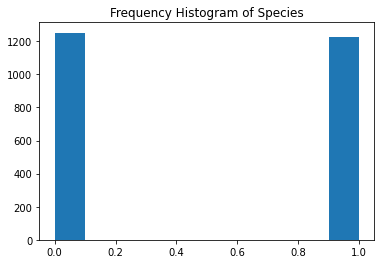

<Figure size 864x864 with 0 Axes>

In [10]:

plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

## Display images of COVID

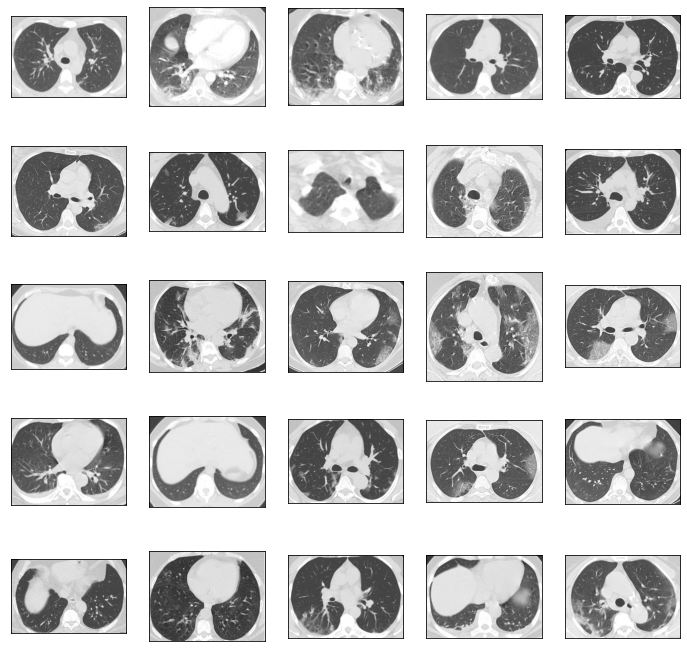

In [11]:

def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

## Display images of non-COVID

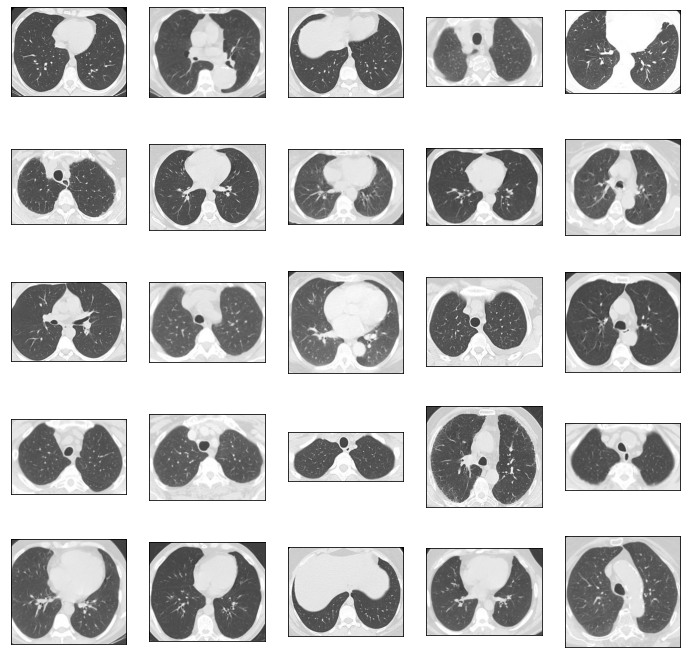

In [12]:

def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

## Image Read and Resize Function

In [13]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Training Images

In [14]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:08, 299.24it/s]


Train Shape: (2481, 64, 64, 3)


## Converting Labels to Categorical

In [15]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

## Train Test Splitting

In [16]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

## 64*64 training images

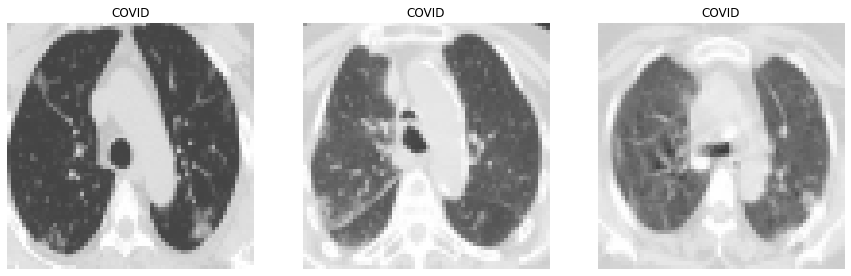

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [18]:
EPOCHS = 50
SIZE=64
N_ch=3

## DenseNet121 Model

In [19]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

## Data Augmentation and Fitting Model 

In [20]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)              

Epoch 39/50

Epoch 00039: val_loss improved from 0.21378 to 0.21327, saving model to model.h5
31/31 - 4s - loss: 0.2301 - accuracy: 0.9047 - val_loss: 0.2133 - val_accuracy: 0.9074
Epoch 40/50

Epoch 00040: val_loss did not improve from 0.21327
31/31 - 3s - loss: 0.2334 - accuracy: 0.9093 - val_loss: 0.2184 - val_accuracy: 0.9054
Epoch 41/50

Epoch 00041: val_loss did not improve from 0.21327
31/31 - 3s - loss: 0.2345 - accuracy: 0.9037 - val_loss: 0.2706 - val_accuracy: 0.8652
Epoch 42/50

Epoch 00042: val_loss did not improve from 0.21327
31/31 - 3s - loss: 0.2352 - accuracy: 0.9047 - val_loss: 0.2361 - val_accuracy: 0.8773
Epoch 43/50

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00043: val_loss did not improve from 0.21327
31/31 - 3s - loss: 0.2145 - accuracy: 0.9098 - val_loss: 0.3536 - val_accuracy: 0.8290
Epoch 44/50

Epoch 00044: val_loss did not improve from 0.21327
31/31 - 3s - loss: 0.2231 - accuracy: 0.9078 - val_loss: 0.2185 - val_accuracy: 0.8994

## Final Loss and Accuracy

In [22]:
#model.save('ct_scan.h5')
model = load_model('ct_scan.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 0s 18ms/step - loss: 0.3415 - accuracy: 0.8753
Final Loss: 0.34146350622177124, Final Accuracy: 0.8752515316009521


## Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

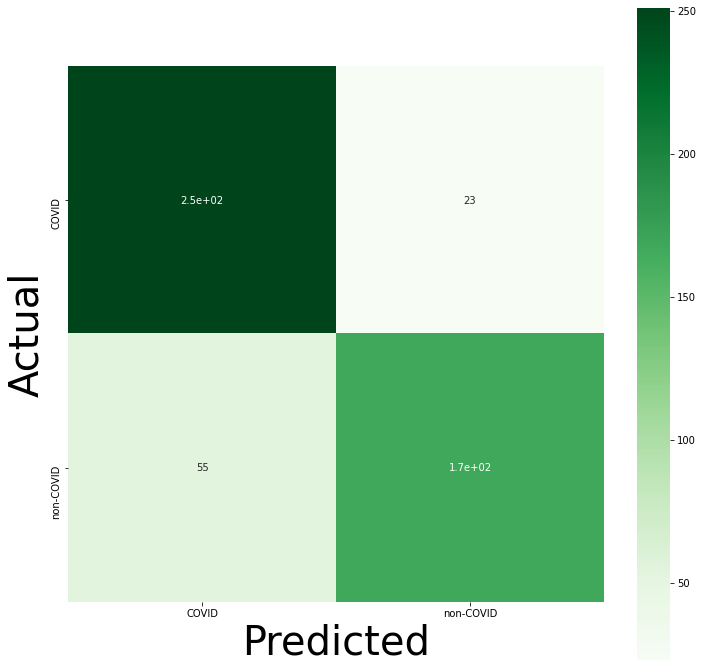

In [21]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Accuracy and Loss Curve

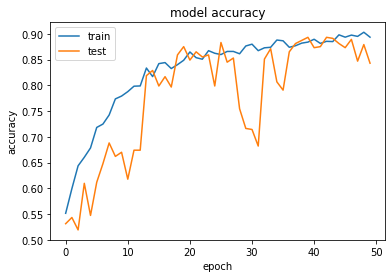

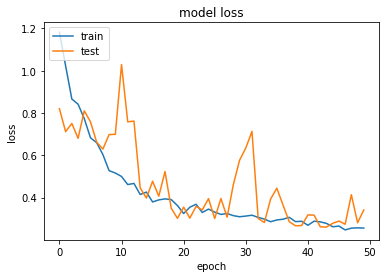

In [22]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction from Image

[9.9942553e-01 5.7452108e-04]


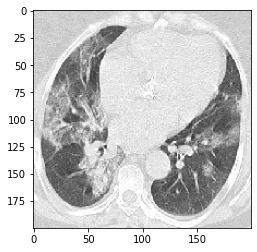

Prediction: Covid-19


In [26]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('./SARS-Cov-2/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('./SARS-Cov-2/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

## If you like this notebook please upvote. Thanks